### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth',200)  #necessary for pileup files

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import analysePileup as aPILEUP
import venn as vn

In [48]:
#CHROM SLICING
minChromFrac = 17.443476
maxChromFrac = 17.491846
#minChromFrac = 17.689695
#maxChromFrac = 17.73896
minChromFrac = 0
maxChromFrac = 26

In [4]:
# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT02020272"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/cancerSample/"
VCF_FILE_NAME = VCF_SAMPLE + "R_" + VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}
# PILEUP CONFIG
PILEUP_PATH = "/Users/peterpriestley/hmf/slice" + VCF_SAMPLE + "/"
NORMAL_PILEUP_FILENAME = VCF_SAMPLE + ".pileup"
TUMOR_PILEUP_FILENAME = VCF_SAMPLE + "T.pileup"

<h3> Load VCFs and Prepare DF

In [44]:
# LOAD PROD VCF and filter
df = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,False)#True,sampleBed)
df = df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]


reading vcf file: CPCT02020272R_CPCT02020272T_merged_somatics.vcf
reading VCF File line: 100000
Number variants loaded: 144553


<h3> SLICE ANALYSIS

In [24]:
# SLICE SETTINGS
SLICE_VCF_PATH = "/Users/peterpriestley/hmf/slice" + VCF_SAMPLE + "/"
SLICE_VCF_FILE_NAME = "somatics.merged.vcf"
SLICE_SAMPLE_NAMES = SAMPLE_NAMES 
dfSlice = aVCF.loadVaraintsFromVCF(SLICE_VCF_PATH,SLICE_VCF_FILE_NAME,SLICE_SAMPLE_NAMES,VCF_SAMPLE,True,False)
dfSlice['Prod']=dfSlice.chromPos.isin(df['chromPos']) 
df['Slice']=df.chromPos.isin(dfSlice['chromPos']) 
dfSlice = dfSlice[(dfSlice.chromFrac > minChromFrac)&(dfSlice.chromFrac < maxChromFrac)]

reading vcf file: somatics.merged.vcf
Number variants loaded: 210


In [45]:
#INTERNAL 'PRECISION' + 'SENSITIVITY' per caller
outputdata = []
variantTypes = df.variantType.unique()
patientNames = df.patientName.unique()
for patientName in patientNames:
    for variantType in variantTypes:
        truthSet = len(df[(df['numCallers'] >= 2)&(df['variantType'] == variantType)&(df['patientName'] == patientName)])
        for columnName in list(df):
            if columnName.endswith('allele'):
                myCaller = columnName[:-6]
                truePositives = len(df[(df[myCaller+'allele'] != '')&(df['numCallers'] >=2) &\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                falseNegatives = len(df[(df[myCaller+'allele'] == '')&(df['numCallers'] >= 2) &\
                                    (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                positives = len(df[(df[myCaller+'allele'] != '')&\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)]) 
                if positives > 0 and truthSet > 0:
                    outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
                else:
                   outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   'na','na'])
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['patientName','variantType','caller','truth','TP','FP','FN',\
                     'intPrecision','intSensitivity'])
outputDF.sort_values(['patientName','variantType','caller'])

,patientName,variantType,caller,truth,TP,FP,FN,intPrecision,intSensitivity
7,CPCT02020272,INDEL,freebayes,562,347,3931,215,0.0811,0.6174
6,CPCT02020272,INDEL,mutect,562,0,0,562,na,na
4,CPCT02020272,INDEL,strelka,562,437,240,125,0.6455,0.7776
5,CPCT02020272,INDEL,varscan,562,539,2324,23,0.1883,0.9591
11,CPCT02020272,Missing Genotype,freebayes,0,0,0,0,na,na
10,CPCT02020272,Missing Genotype,mutect,0,0,0,0,na,na
8,CPCT02020272,Missing Genotype,strelka,0,0,0,0,na,na
9,CPCT02020272,Missing Genotype,varscan,0,0,0,0,na,na
3,CPCT02020272,SNP,freebayes,40047,3582,24810,36465,0.1262,0.0894
2,CPCT02020272,SNP,mutect,40047,38321,23505,1726,0.6198,0.9569


In [18]:
#INTERNAL 'PRECISION' + 'SENSITIVITY' per caller - SLICE
outputdata = []
variantTypes = dfSlice.variantType.unique()
patientNames = dfSlice.patientName.unique()
for patientName in patientNames:
    for variantType in variantTypes:
        truthSet = len(dfSlice[(dfSlice['numCallers'] >= 2)&(dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)])
        for columnName in list(dfSlice):
            if columnName.endswith('allele'):
                myCaller = columnName[:-6]
                truePositives = len(dfSlice[(dfSlice[myCaller+'allele'] != '')&(dfSlice['numCallers'] >=2) &\
                                   (dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)])
                falseNegatives = len(dfSlice[(dfSlice[myCaller+'allele'] == '')&(dfSlice['numCallers'] >= 2) &\
                                    (dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)])
                positives = len(dfSlice[(dfSlice[myCaller+'allele'] != '')&\
                                   (dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)]) 
                if positives > 0 and truthSet > 0:
                    outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
                else:
                   outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   'na','na'])
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['patientName','variantType','caller','truth','TP','FP','FN',\
                     'intPrecision','intSensitivity'])
outputDF.sort_values(['patientName','variantType','caller'])

,patientName,variantType,caller,truth,TP,FP,FN,intPrecision,intSensitivity
7,CPCT02020272,INDEL,freebayes,2,2,14,0,0.125,1
6,CPCT02020272,INDEL,mutect,2,0,0,2,na,na
4,CPCT02020272,INDEL,strelka,2,0,2,2,0,0
5,CPCT02020272,INDEL,varscan,2,2,7,0,0.2222,1
3,CPCT02020272,SNP,freebayes,59,17,15,42,0.5313,0.2881
2,CPCT02020272,SNP,mutect,59,48,35,11,0.5783,0.8136
0,CPCT02020272,SNP,strelka,59,49,71,10,0.4083,0.8305
1,CPCT02020272,SNP,varscan,59,16,5,43,0.7619,0.2712


In [35]:
df[(df.numCallers>0)&(df.freebayesAF!='')].head(30)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,filter,strelkaallele,strelkaAF,strelkaDP,strelkaQS,strelkasomaticGT,varscanallele,varscanAF,varscanDP,varscanQS,varscansomaticGT,mutectallele,mutectAF,mutectDP,mutectQS,mutectsomaticGT,freebayesallele,freebayesAF,freebayesDP,freebayesQS,freebayessomaticGT,patientName
118284,17,36119907,17:36119907,17.444853,T,,4,SNP,,PASS,A,0.46875,129,104,ref,A,0.4715,123,145,2,A,0.472,125,-1,ref-het,A,0.476562,128,1751.3,unknown,CPCT02020272
118288,17,36275054,17:36275054,17.446763,T,,1,SNP,,.,,,,,,,,,,,,,,,,C,0.229358,109,25.22,somatic,CPCT02020272
118289,17,36276690,17:36276690,17.446784,ATTTTTTTTTTTTTG,,1,INDEL,INSERT,.,,,,,,,,,,,,,,,,ATTTTTTTTTTTTTTTG,0.304878,198,74.08,somatic,CPCT02020272
118295,17,36325755,17:36325755,17.447388,A,,2,SNP,,PASS,,,,,,T,0.1724,58,18,2,,,,,,T,0.309859,72,69.95,somatic,CPCT02020272
118299,17,36543096,17:36543096,17.450065,G,,1,SNP,,.,,,,,,,,,,,,,,,,A,0.566667,31,365.39,somatic,CPCT02020272
118300,17,36543098,17:36543098,17.450065,GTATATATATATATATAT,,1,INDEL,INSERT,.,,,,,,,,,,,,,,,,GTATATATATATATATATAT,0.916667,27,1263.66,somatic,CPCT02020272
118303,17,36675270,17:36675270,17.451693,G,,1,SNP,,.,,,,,,,,,,,,,,,,A,0.201835,109,39.7,somatic,CPCT02020272
118315,17,36850732,17:36850732,17.453854,C,,4,SNP,,PASS,A,0.433333,90,92,ref,A,0.4318,88,90,2,A,0.442,86,-1,ref-het,A,0.438202,89,1072.01,unknown,CPCT02020272
118320,17,37012634,17:37012634,17.455847,CAAAAAAAAAAAAAC,,1,INDEL,DELETE,.,,,,,,,,,,,,,,,,CAAAAAAAAAAAAC,0.919355,66,2303.37,somatic,CPCT02020272
118331,17,37353046,17:37353046,17.460040,T,,1,SNP,,.,,,,,,,,,,,,,,,,G,0.337349,83,152.03,somatic,CPCT02020272


<h3> PILEUP ANALYSIS

In [ ]:
#TODO
#Easy display of output - #of ref. # of others

In [55]:
normalPileup = aPILEUP.readPileup(PILEUP_PATH,NORMAL_PILEUP_FILENAME,dfSlice[['chrom','pos']].values.tolist())
tumorPileup = aPILEUP.readPileup(PILEUP_PATH,TUMOR_PILEUP_FILENAME,dfSlice[['chrom','pos']].values.tolist())

In [56]:
dfSlice = dfSlice.set_index(['chrom','pos'])
normalPileup = normalPileup.set_index(['chrom','pos'])
tumorPileup = tumorPileup.set_index(['chrom','pos'])
dfSlice = pd.merge(dfSlice,normalPileup, left_index=True,right_index=True,suffixes=('', '_N'))
dfSlice = pd.merge(dfSlice,tumorPileup, left_index=True,right_index=True,suffixes=('', '_T'))

In [59]:
myCaller = 'mutect'
temp = dfSlice[[myCaller+'AF','variantSubType',myCaller+'QS','Prod','numCallers','DP','DP_T',myCaller+'DP','Bases','Bases_T','BaseQ','BaseQ_T', 'ref',myCaller+'allele',myCaller+'QS',myCaller+'somaticGT']][dfSlice[myCaller+'allele']!='']
temp

mutectAF variantSubType mutectQS  Prod  numCallers   DP DP_T mutectDP                                                                                                                                                                Bases                                                                                                                                                                                                  Bases_T                                                                                                                                                        BaseQ                                                                                                                                                                                                  BaseQ_T ref mutectallele mutectQS mutectsomaticGT
chrom pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
17    36119907    0.472                      -1  True           4   72  123      125                                                                                             .,,,,,,,.,,,,,...,,,,.,..,...,..,,.,,,,,...,,.,.,.,,....,.,.....,..,,...                                                                             .$.,a,AA.A.,,aAa,,AAa,.,aa,aA.aAa,.a.aaa,AA,Aa.,a.,,a.AA..,.A,A.Aa.a..AA,,A.AA.aa,..,..AAA..,aA,.a.,AAAa,,..a,a,..a,Aa.AA,,.                                                                                     KKKKKKFKKKKKKKKkKKKKKKKKKKKKVKKKKKKKKK<KKKKFFKAKAKKKKKKKKKKKKKKKKKFFKKFF                                                                              DKFFFFKAuKKKKKKKKKKKKKKKKKFKKKKKKFKKKKKKFKKKKAKKKKKKKKKKKKKKKKKKKKKKKK<KKFKKKKKKKKpKKFKKKKFKKKKK<KKKKKKKKKKFFKKKKKAK7KKKKAF   T            A       -1         ref-het
      36153411    0.046                      -1  True           1   46  108      109                                                                                                                       ...,.,...,.,..,.,..,.,..,.,.,,....,,,,,,..,,.,                                                                                            .$...,..,......,.,,.,.,,,.,,,,..,.,.,,,,.,,,,.,.,,c,,.,..c.,,,..,.,,..,......,....,c,.,,.,,,,....c,,.,,..,,,.                                                                                                               uuKKKKKuKKKKKKKKKKFKKKKKKuKKKKKKKKKKKKKKKKKKKK                                                                                             >EEEAKKFKKFKKKKAKKKKKKKKKKKKKFKKKKKKKKKuKKKKKK<KKKFKKKKKKFKKFKKKFKKKKKKKKKKKKKKK<KKKFKKFK7KKKKKKKKKKKKFKKFKF   G            C       -1         ref-het
      36159135     0.04                      -1  True           2   45  100      101                                                                                                                       ,$..,...,,,.,,,,,.,.,.,,,,,,.,,.,....,.,....,.                                                                                                     ...,.,,.,,,..,.,,,,..,,,,t,.,.,,,.,,,,,,,,,,,.,,,,.,,.,....,,,,,..,,,T.,,...,.,TT,,..,,,,,....,,,,.,                                                                                                                ApKKpFKKKKKKKKKKKK<KKKKKKKKKKKKKKKKKKK7AKKKKF    

<h3> SNP

In [53]:
snpdf = df[(df.variantType == 'SNP')]

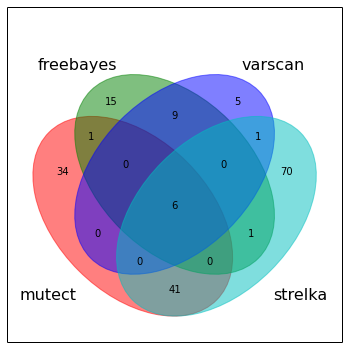

In [32]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= dfSlice[(dfSlice.variantType == 'INDEL')]

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

<h3> Allelic Depth

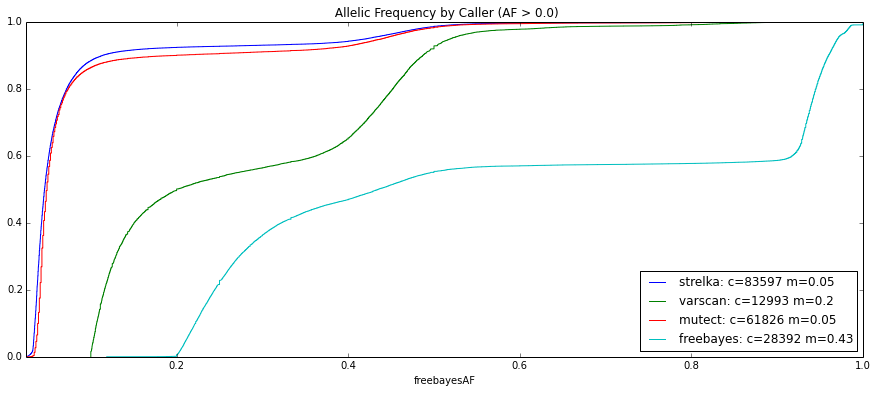

In [54]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AF > 0.0)",figsize=[15,6])

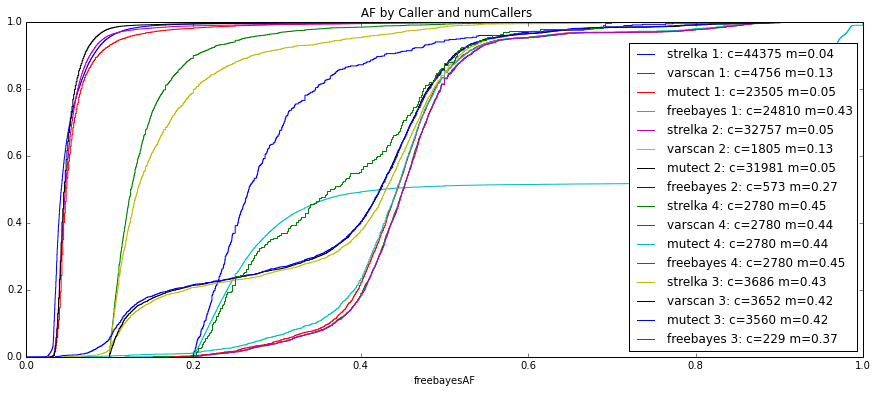

In [50]:
# BY CALLER AND numCallers
numCallers = snpdf.numCallers.unique()
for numCaller in numCallers:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.numCallers == numCaller) &(snpdf[columnName] != '')][columnName[:-6] + 'AF']
            if len(ser) > 0:
                ser = ser.sort_values()
                #ser[len(ser)] = ser.iloc[-1]
                cum_dist = np.linspace(0.,1.,len(ser))
                ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(numCaller)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
                ser_cdf.plot(drawstyle='steps',legend=True,title=" AF by Caller and numCallers",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''